# Encode data

In [1]:
pip install tqdm matplotlib pinecone-client sentence-transformers tiktoken langchain requests python-dotenv widgetsnbextension

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.9/215.9 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade jupyter

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 49.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.1
    Uninstalling widgetsnbextension-3.6.1:
      Successfully uninstalled widgetsnbextension-3.6.1
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 1.1.1
    Uninstalling jupyterlab-widgets-1.1.1:
      Successfully uninstalled jupyterlab-widgets-1.1.1
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Setup

In [5]:
# Python version
import sys 
print(sys. version)

3.9.13 (main, May 23 2022, 22:01:06) 
[GCC 9.4.0]


In [6]:
# Environment Variables
from dotenv import load_dotenv
import yaml
import os

# Load env
load_dotenv()

False

In [7]:
# Torch config
from torch import cuda, bfloat16, float16
import torch

# Torch options
#torch.backends.cuda.enable_mem_efficient_sdp(False)
#torch.backends.cuda.enable_flash_sdp(False)

# Parameters

In [8]:
# Load parameters from YAML file
import os

# Change the current working directory to the directory containing the YAML file
os.chdir('/notebooks/TFM/TFM_LAW_LLM')

# Load parameters from YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Reference

- https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/llm-field-guide/llama-2/llama-2-13b-retrievalqa.ipynb#scrollTo=yjs-uPXBrnQs
- https://github.com/langchain-ai/langchain/blob/master/cookbook/RAPTOR.ipynb
- https://www.youtube.com/watch?v=LhnCsygAvzY&ab_channel=JamesBriggs
- https://huggingface.co/spaces/mteb/leaderboard

# Directory

In [9]:
# Set directory to file location
from pathlib import Path
import sys
notebook_location = Path(os.path.abspath(''))
os.chdir(notebook_location)

# Get the current working directory
current_directory = os.getcwd()
current_directory

'/notebooks/TFM/TFM_LAW_LLM'

# Libraries

In [10]:
# General libraries

# Time data managment libraries 
import time

# Garbage Collecting library: automatically freeing up memory occupied by objects that are no longer in use by the program
import gc

# Local assets: Utils contains functions we will later use
from utils import *

# Progress bars
import tqdm
from tqdm.notebook import tqdm

# Directory managment
import os

# Plots
import matplotlib.pyplot as plt

# Embeddings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

# Vector Database
from pinecone import Pinecone


In [11]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
# Start timing the notebook run
start_time = time.time()

# Device

In [13]:
# Setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# CUDA information
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    allocated_memory = torch.cuda.memory_allocated(0) / (1024**3)  # Convert bytes to GB
    cached_memory = torch.cuda.memory_reserved(0) / (1024**3)  # Convert bytes to GB
    total_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)  # Convert bytes to GB
    available_memory = total_memory - cached_memory
    print('Allocated:   ', round(allocated_memory, 1), 'GB')
    print('Cached:      ', round(cached_memory, 1), 'GB')
    print('Available:  ', round(available_memory, 1), 'GB')
    print('Total:      ', round(total_memory, 1), 'GB')

Using device: cuda

NVIDIA RTX A4000
Memory Usage:
Allocated:    0.0 GB
Cached:       0.0 GB
Available:   15.7 GB
Total:       15.7 GB


In [14]:
# Clean memory
torch.cuda.empty_cache()
gc.collect()

224

# Load data

We load the splitted data from 2_transform_data.ipynb notbook.

In [15]:
# Params
folder_path = "prepared_data/"
file_name = "splitted_input_base.csv"
file_path = f'{folder_path}{file_name}'

# Read csv
df_txt = pd.read_csv(file_path)

# Format
df_txt['text_id'] = df_txt['text_id'].astype(str)

# Show
df_txt.head()

,text_id,text
0,chunk_1,"LEY ORGÁNICA 10/1995, DE 23 DE NOVIEMBRE, DEL\..."
1,chunk_2,JUAN CARLOS I\nRey de España\nA todos los que ...
2,chunk_3,negativa». El Código Penal ha de tutelar los v...
3,chunk_4,"sucinto, los criterios en que se inspira, aunq..."
4,chunk_5,"menos básicos, y, de otra, introduce cambios e..."


In [16]:
# Length of file
len(df_txt)

1068

# Check the Metadata

In [17]:
# # Count of rows for each value of legislative_origin
# legislative_origin_counts = df_txt['legislative_origin'].value_counts()

# # Count of rows for each value of department
# department_counts = df_txt['department'].value_counts()

# # Count of rows for each value of rang
# rang_counts = df_txt['rang'].value_counts()

# # Print the counts
# print("Count of rows for each value of legislative_origin:")
# print(legislative_origin_counts)
# print("\nCount of rows for each value of department:")
# print(department_counts)
# print("\nCount of rows for each value of rang:")
# print(rang_counts)

# Filter for Pinecone Insert

## Number of chunks

In [18]:
# Maximum number of chunks
max_number_chunks = 100000

In [19]:
# Limit the DataFrame size
df_txt = df_txt.head(max_number_chunks)

In [20]:
# Show
df_txt.head()

,text_id,text
0,chunk_1,"LEY ORGÁNICA 10/1995, DE 23 DE NOVIEMBRE, DEL\..."
1,chunk_2,JUAN CARLOS I\nRey de España\nA todos los que ...
2,chunk_3,negativa». El Código Penal ha de tutelar los v...
3,chunk_4,"sucinto, los criterios en que se inspira, aunq..."
4,chunk_5,"menos básicos, y, de otra, introduce cambios e..."


In [21]:
# Length of file

print(f"Number of chunks: {len(df_txt)}.")

Number of chunks: 1068.


## Byte size per vector

We filter the chunks that have less than max_bytes parameter.

In [22]:
# Maximum bytes
max_bytes = 40000

In [23]:
df_txt = filter_df_by_byte_count(df_txt, max_bytes)

In [24]:
# Length of file
len(df_txt)

1068

## Tokens per vector

We count the number of tokens each vector or text has.

In [25]:
# Check tokens count per vector
df_tokens_check = df_txt.copy()

# Apply function
df_tokens_check['token_count'] = df_txt['text'].apply(count_tokens)

# Sort
df_tokens_check = df_tokens_check.sort_values(by='token_count', ascending=False)

# Filter
cols = ['text_id', 'text', 'token_count']
df_tokens_check[cols]

# Show
df_tokens_check.head()

,text_id,text,num_bytes,token_count
1003,chunk_1004,No limitación de los Jueces a las cuantías mín...,1066,408
999,chunk_1000,"Alimentos, 364.\nAparatos automáticos, 283.\nB...",1053,384
1059,chunk_1060,"R\nRacismo, 607.\nAgravante, 22.4.\nDiscrimina...",1036,384
1008,chunk_1009,"C\nCadáveres:\nDespojo de efectos, 612.7.º\nPr...",1077,371
1040,chunk_1041,"Detenciones ilegales y secuestros, 167.\nEncub...",1031,370


Histogram of the Token Count

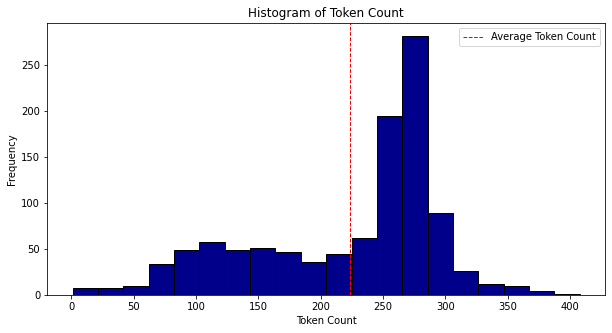

In [26]:
# Calculate average token count
average_token_count = df_tokens_check['token_count'].mean()

# Create a larger figure
plt.figure(figsize=(10, 5))

# Create histogram
plt.hist(df_tokens_check['token_count'], bins=20, color='darkblue', edgecolor='black')

# Add vertical line for average token count
plt.axvline(average_token_count, color='red', linestyle='dashed', linewidth=1)

# Add labels and title
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Histogram of Token Count')

# Add legend for the vertical line
plt.legend(['Average Token Count'])

# Show histogram
plt.show()

# Pinecone

In [27]:
import os
use_serverless = True

from pinecone import Pinecone

In [28]:
# Initialize pinecone
pinecone = Pinecone(api_key = "03b29f67-c297-4462-825b-13ce23b3d577")

pc = Pinecone(api_key = pinecone)

In [29]:
from pinecone import ServerlessSpec, PodSpec

if use_serverless:
    spec = ServerlessSpec(cloud='aws', region='us-east-1')
# else:
#     spec = podSpec(environment=environment)    

index_name = 'lawllm-unstructured-database'

if index_name in pinecone.list_indexes().names():
    pinecone.delete_index(index_name)

In [30]:

# Connect
index_name = 'lawllm-unstructured-database'

dimensions = 768
pinecone.create_index(
    name = index_name,
    dimension = dimensions,
    metric = "cosine",
    spec = spec)

In [31]:
index = pinecone.Index(index_name)

# Index stats
index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

# Embedding model

In [32]:
# Model ID
embed_model_id = config["embedding_model"]

# Show
embed_model_id

'sentence-transformers/multi-qa-mpnet-base-cos-v1'

In [33]:
# Embed model
embed_model = HuggingFaceEmbeddings(
    model_name = embed_model_id,
    model_kwargs = {'device': device},
    encode_kwargs = {'device': device, 'batch_size': 32}
)

# Show
embed_model

Downloading:   0%|          | 0.00/791 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.25k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
), model_name='sentence-transformers/multi-qa-mpnet-base-cos-v1', cache_folder=None, model_kwargs={'device': device(type='cuda')}, encode_kwargs={'device': device(type='cuda'), 'batch_size': 32}, multi_process=False, show_progress=False)

In [34]:
# CUDA information
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    allocated_memory = torch.cuda.memory_allocated(0) / (1024**3)  # Convert bytes to GB
    cached_memory = torch.cuda.memory_reserved(0) / (1024**3)  # Convert bytes to GB
    total_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)  # Convert bytes to GB
    available_memory = total_memory - cached_memory
    print('Allocated:   ', round(allocated_memory, 1), 'GB')
    print('Cached:      ', round(cached_memory, 1), 'GB')
    print('Available:  ', round(available_memory, 1), 'GB')
    print('Total:      ', round(total_memory, 1), 'GB')

NVIDIA RTX A4000
Memory Usage:
Allocated:    0.0 GB
Cached:       0.0 GB
Available:   15.7 GB
Total:       15.7 GB


# Delete existing data

We need to make sure there is no any data in the Pinecone Index before inserting our data.

In [35]:
from pinecone.exceptions import NotFoundException

try:
    index.delete(delete_all=True)
except NotFoundException:
    print("Namespace not found. Skipping deletion.")
except Exception as e:
    print("Error:", e)

Namespace not found. Skipping deletion.


In [36]:
# Stats
index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

# Insert to DB

Let's now insert our own data to the Pinecone database.

In [37]:
# Define batch size
batch_size = config['batch_size']

In [38]:
# Embed and insert loop
for i in tqdm(range(0, len(df_txt), batch_size), desc='Processing insertion'):
    
    # Batch processing
    i_end = min(len(df_txt), i + batch_size)
    batch = df_txt.iloc[i:i_end]
    
    # Convert potential float values to string in text-related columns
    batch['text_id'] = batch['text_id'].astype(str)
    batch['text'] = batch['text'].astype(str)
    
    # Text Ids formatting
    text_ids = batch['text_id'].tolist()
    texts = batch['text'].tolist()
    
    # Embed texts
    embeds = embed_model.embed_documents(texts)
    
    # Get metadata to store in DB
    metadata = [
        {'text_id': str(x['text_id']),
         'text': str(x['text'])
        } for _, x in batch.iterrows()
    ]
    
    # Add to Pinecone
    data_to_upsert = zip(text_ids, embeds, metadata)
    
    # Upsert to Pinecone
    index.upsert(data_to_upsert)

Processing insertion:   0%|          | 0/22 [00:00<?, ?it/s]

In [39]:
# Stats
index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}

# Clean

In [40]:

# CUDA information
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    allocated_memory = torch.cuda.memory_allocated(0) / (1024**3)  # Convert bytes to GB
    cached_memory = torch.cuda.memory_reserved(0) / (1024**3)  # Convert bytes to GB
    total_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)  # Convert bytes to GB
    available_memory = total_memory - cached_memory
    print('Allocated:   ', round(allocated_memory, 1), 'GB')
    print('Cached:      ', round(cached_memory, 1), 'GB')
    print('Available:  ', round(available_memory, 1), 'GB')
    print('Total:      ', round(total_memory, 1), 'GB')

NVIDIA RTX A4000
Memory Usage:
Allocated:    0.4 GB
Cached:       3.8 GB
Available:   12.0 GB
Total:       15.7 GB


In [41]:
# Clean memory
torch.cuda.empty_cache()
gc.collect()

251

# Runtime

In [42]:
# End time of notebook run
end_time = time.time()
elapsed_time = end_time - start_time

# Convert elapsed time to hours and minutes
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)

# Print the result
print(f"Time elapsed: {hours} hours and {minutes} minutes.")

Time elapsed: 0 hours and 0 minutes.
